In [1]:
import pandas as pd
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from xgboost import XGBRegressor
from tqdm import tqdm
import unicodedata
import subprocess
import importlib
import swifter 
import joblib
import spacy
import ijson
import nltk
import json
import re
import os

h:\IA_prédiction\venv_ia_tickets_v2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:

from spacy.util import is_package
from spacy.cli import download

# 📦 Téléchargement auto des stopwords NLTK
try:
    stop_fr = set(stopwords.words('french'))
    stop_en = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_fr = set(stopwords.words('french'))
    stop_en = set(stopwords.words('english'))

# 🧠 Initialisation des correcteurs d'orthographe
spell_fr = SpellChecker(language='fr')
spell_en = SpellChecker(language='en')

# 🧠 Fonction de chargement sécurisé des modèles spaCy
def safe_spacy_load(model_name):
    if is_package(model_name):
        return spacy.load(model_name)
    else:
        print(f"🔄 Modèle {model_name} non installé. Téléchargement en cours...")
        download(model_name)
        print(f"✅ Modèle {model_name} téléchargé. 🔁 Veuillez redémarrer le kernel, puis relancer la cellule.")
        return None

# 📦 Chargement des modèles linguistiques
nlp_fr = safe_spacy_load("fr_core_news_sm")
nlp_en = safe_spacy_load("en_core_web_sm")

if nlp_fr is None or nlp_en is None:
    raise SystemExit("🛑 Redémarre le kernel avant de continuer. Modèles téléchargés.")

In [2]:
# 1. Charger le fichier Excel et extraire les Jira utiles
zh12 = pd.read_excel("export_ZH12.xlsx")
zh12["Date"] = pd.to_datetime(zh12["Date"], dayfirst=True, errors='coerce')
zh12 = zh12.dropna(subset=["Date", "Jira"])
jira_keys_excel = set(zh12["Jira"].unique())

h:\IA_prédiction\venv_ia_tickets_v2\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell B2303 is marked as a date but the serial value -693595 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
h:\IA_prédiction\venv_ia_tickets_v2\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell B2304 is marked as a date but the serial value -693595 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
h:\IA_prédiction\venv_ia_tickets_v2\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell B48783 is marked as a date but the serial value -693595 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
h:\IA_prédiction\venv_ia_tickets_v2\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell B48784 is marked as a date but the serial value -693595 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
h:\IA_prédiction\v

In [3]:


# Lecture progressive avec ijson
filtered_issues = []
with open("jira_merged.json", "r", encoding="utf-8") as f:
    for issue in ijson.items(f, "issues.item"):
        if issue.get("key") in jira_keys_excel:
            filtered_issues.append(issue)

# Normaliser en DataFrame
jira_df = pd.json_normalize(filtered_issues)
jira_df.to_csv("jira_filtered_flat.csv", index=False, sep=";", encoding="utf-8")
print(f"✅ {len(jira_df)} tickets filtrés et exportés.")


✅ 12635 tickets filtrés et exportés.


In [ ]:
# Agrégation : total d'heures par (Matricule, Jira)
aggr = zh12.groupby(["Matricule", "Jira"], as_index=False).agg({
    "Durée tâche (heures)": "sum",
    "Code Service": "first",
    "Date": "min"  # La date la plus ancienne
})

# Renommer la colonne de date
aggr.rename(columns={"Date": "Date commence"}, inplace=True)

# Sauvegarde dans un fichier CSV
aggr.to_csv("zh12_aggregated.csv", index=False, sep=";", encoding="utf-8")

print("✅ Fichier 'zh12_aggregated.csv' généré avec succès.")


NameError: name 'zh12' is not defined

In [3]:
# Lecture du fichier agrégé depuis zh12
aggr = pd.read_csv("zh12_aggregated.csv", sep=";", encoding="utf-8")

# Lecture du fichier Jira filtré et aplati
jira_df = pd.read_csv("jira_filtered_flat.csv", sep=";", encoding="utf-8", low_memory=False)

# Vérification rapide
print("✅ zh12_aggregated.csv :", aggr.shape)
print("✅ jira_filtered_flat.csv :", jira_df.shape)


✅ zh12_aggregated.csv : (16532, 5)
✅ jira_filtered_flat.csv : (12635, 780)


In [10]:
jira_df["fields.summary"]

0                                      API continuity plan
1                                     Départ Octapharma BE
2        431 BMS – Name Change of Distribution Channel ...
3               Modification transaction de retour Perrigo
4                     [BMS] Implémentation Bolloré Back-up
                               ...                        
12630                                   Ralentissement SAP
12631    Plus d'impression sur certains poste ( code er...
12632                                   blocage compte SAP
12633                          RE: Code absence FOR  SI-RH
12634                                       test ULIS 0309
Name: fields.summary, Length: 12635, dtype: object

In [5]:
# Caches pour optimiser
correction_cache = {}
lemmatisation_cache = {}

# Liste blanche de mots techniques/acronymes à préserver
whitelist = {"idoc", "sap", "vpn", "teams", "jira", "sql", "pdf", "ssl"}

def clean_encoding(text):
    try:
        text = text.encode('latin1').decode('utf-8')
    except:
        pass
    text = text.replace("�", "")
    return unicodedata.normalize('NFKC', text)

def corriger_orthographe(mot):
    if mot in correction_cache:
        return correction_cache[mot]
    corr = spell_fr.correction(mot)
    if corr is None or corr == mot:
        corr = spell_en.correction(mot)
    correction_cache[mot] = corr if corr else mot
    return correction_cache[mot]

def lemmatiser_mot(mot):
    if mot in lemmatisation_cache:
        return lemmatisation_cache[mot]
    doc_fr = nlp_fr(mot)
    if doc_fr and doc_fr[0].lemma_ != mot:
        lemmatisation_cache[mot] = doc_fr[0].lemma_
        return lemmatisation_cache[mot]
    doc_en = nlp_en(mot)
    lemmatisation_cache[mot] = doc_en[0].lemma_ if doc_en else mot
    return lemmatisation_cache[mot]

def preprocess_libelle(text):
    if not isinstance(text, str):
        return ""
    # Nettoyage de l'encodage et de la ponctuation
    text = clean_encoding(text)
    text = re.sub(r"[^\w\s]", " ", text)
    mots = text.split()

    mots_cles = []
    for m in mots:
        m_lower = m.lower()
        # Option 1 : ignorer les majuscules (acronymes)
        if m.isupper() and len(m) > 2:
            mots_cles.append(m_lower)
            continue
        # Option 2 : ignorer les mots en whitelist
        if m_lower in whitelist:
            mots_cles.append(m)
            continue
        # Option 3 : stop words + correction/lemmatisation
        if m not in stop_fr and m not in stop_en and len(m) > 2:
            mot_corr = corriger_orthographe(m_lower)
            mot_lem = lemmatiser_mot(mot_corr)
            mots_cles.append(mot_lem)
    return " ".join(mots_cles)


In [ ]:
# Application avec swifter ou tqdm si swifter indisponible
swifter.set_defaults(pbar=True, progress_bar=True, allow_dask_on_strings=True, error_score="raise")
jira_df["fields.summary"] = jira_df["fields.summary"].fillna("")
jira_df["summary"] = jira_df["fields.summary"].swifter.apply(preprocess_libelle)

In [ ]:
# Application avec swifter ou tqdm si swifter indisponible
swifter.set_defaults(pbar=True, progress_bar=True, allow_dask_on_strings=True, error_score="raise")
jira_df["fields.description"] = jira_df["fields.description"].fillna("")
jira_df["description"] = jira_df["fields.description"].swifter.apply(preprocess_libelle)

In [ ]:
jira_df.to_csv("jira_libelle_clean.csv", index=False, sep=";", encoding="utf-8")

In [ ]:
jira_df["fields.components"]

0                 Change
1                 Change
2                 Change
3               Sub-task
4                 Change
              ...       
12630           Incident
12631           Incident
12632           Incident
12633    Service Request
12634           Incident
Name: fields.issuetype.name, Length: 12635, dtype: object

In [ ]:

# jira_df = pd.read_csv("jira_libelle_clean.csv", sep=";", encoding="utf-8")
aggr = pd.read_csv("zh12_aggregated.csv", sep=";", encoding="utf-8")
jira_df = pd.read_csv("jira_libelle_clean.csv", sep=";", encoding="utf-8")
jira_df["nb_key"] = jira_df["key"].str.extract(r"-(\d+)", expand=False).astype(int)


In [ ]:
import ast

merged_df = aggr.merge(jira_df, left_on="Jira", right_on="key", how="left")
merged_df = merged_df[merged_df["fields.resolution.name"] == "Done"].copy()

# Corrige les valeurs str -> liste de dicts
merged_df["fields.components"] = merged_df["fields.components"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)

# ✅ Extraire les noms des composants et les fusionner par "/"
merged_df["components"] = merged_df["fields.components"].apply(
    lambda comps: " / ".join(
        [c["name"] for c in comps if isinstance(c, dict) and "name" in c]
    ) if isinstance(comps, list) else None
)

def construire_type_etendu(row, colonnes):
    valeurs = []
    for col in colonnes:
        val = str(row.get(col, "")).strip()
        if val:
            valeurs.append(val)
    return "__".join(valeurs) if valeurs else None

colonnes_type = ["fields.issuetype.name", "components", "fields.customfield_10116.value"]
merged_df["Type_Étendu"] = merged_df.apply(lambda row: construire_type_etendu(row, colonnes_type), axis=1)


# 🧹 Suppression des lignes sans composants (None ou vide)
merged_df = merged_df.dropna(subset=["Type_Étendu"])
merged_df = merged_df[merged_df["Type_Étendu"].str.strip() != ""].reset_index(drop=True)


print(f"✅ Fusion terminée : {merged_df.shape[0]} lignes")

NameError: name 'aggr' is not defined

In [108]:
merged_df[["key", "fields.created"]]

,key,fields.created
0,ULIS-14638,2023-01-04T08:47:25.397+0100
1,SCMF-2393,2023-07-03T14:58:28.598+0200
2,SCMF-2668,2024-01-24T09:56:24.113+0100
3,ULIS-25615,2024-09-24T16:08:07.060+0200
4,ULIS-25617,2024-09-24T16:32:58.021+0200
...,...,...
14508,ULIS-33104,2025-06-24T13:18:19.080+0200
14509,ULIS-33130,2025-06-25T11:54:32.854+0200
14510,ULIS-33163,2025-06-26T14:50:17.917+0200
14511,ULIS-33310,2025-06-30T06:38:00.744+0200


In [109]:
# Forcer le parsing avec UTC
merged_df["fields.created"] = pd.to_datetime(merged_df["fields.created"], errors="coerce", utc=True)

# Supprimer la timezone pour garder une datetime simple (naive)
merged_df["fields.created"] = merged_df["fields.created"].dt.tz_convert(None)

# Créer une colonne formatée proprement
merged_df["fields.created"] = merged_df["fields.created"].dt.date


In [118]:
merged_df[["key", "fields.created"]]

,key,fields.created
0,ULIS-14638,2023-01-04
1,SCMF-2393,2023-07-03
2,SCMF-2668,2024-01-24
3,ULIS-25615,2024-09-24
4,ULIS-25617,2024-09-24
...,...,...
14365,ULIS-33104,2025-06-24
14366,ULIS-33130,2025-06-25
14367,ULIS-33163,2025-06-26
14368,ULIS-33310,2025-06-30


In [ ]:
# # Version percentile 99%
# seuil_max = merged_df["Duree"].quantile(0.99)
# merged_df = merged_df[merged_df["Duree"] <= seuil_max].copy()

mean = merged_df["Duree"].mean()
std = merged_df["Duree"].std()
merged_df = merged_df[merged_df["Duree"] <= mean + 3 * std]

In [ ]:
# Conversion en datetime (avec gestion de fuseau)
merged_df["fields.created"] = pd.to_datetime(merged_df["fields.created"], errors="coerce")

merged_df.rename(columns={"Durée tâche (heures)": "Duree"}, inplace=True)

# Historique glissant 1 an basé sur Type_Étendu
history = []
for idx, row in merged_df.iterrows():
    matricule = row["Matricule"]
    key = row["fields.project.key"]
    typ = row["Type_Étendu"]
    date = row["fields.created"]
    if pd.isna(matricule) or pd.isna(typ) or pd.isna(date):
        history.append(None)
        continue

    date_min = date - timedelta(days=365)
    past_tasks = merged_df[
        # (merged_df["Matricule"] == matricule) &
        (merged_df["fields.project.key"] == key) &
        (merged_df["Type_Étendu"] == typ) &
        (merged_df["fields.created"] < date) &
        (merged_df["fields.created"] >= date_min)
    ]
    mean_val = past_tasks["Duree"].mean() if not past_tasks.empty else None
    history.append(mean_val)

merged_df["Historique_1an"] = history
merged_df["Historique_1an"] = merged_df["Historique_1an"].fillna(0)

# Affichage final (échantillon)
print(merged_df[["Matricule", "fields.project.key", "nb_key", "Duree", "Type_Étendu", "Date commence", "fields.created", "Historique_1an"]].head())


   Matricule fields.project.key   nb_key  Duree  \
0    7000100               ULIS  14638.0   1.00   
1        719               SCMF   2393.0   2.00   
2        719               SCMF   2668.0   3.00   
3        719               ULIS  25615.0   1.20   
4        719               ULIS  25617.0   1.12   

                                      Type_Étendu Date commence  \
0  Service Request__GLS - Licence SAP__Healthcare    2023-01-04   
1          Change__JP6 - 431 BMS (FR)__Healthcare    2024-09-24   
2             Change__JP6 - 440 Roche__Healthcare    2024-09-24   
3             Incident__JP6 - 362 FME__Healthcare    2024-09-24   
4  Service Request__GLS - Licence SAP__Healthcare    2024-09-24   

  fields.created  Historique_1an  
0     2023-01-04        1.649062  
1     2023-07-03       12.342500  
2     2024-01-24       10.004375  
3     2024-09-24        4.193467  
4     2024-09-24        1.378125  


In [6]:
# ✅ Conversion correcte de fields.created
merged_df["fields.created"] = pd.to_datetime(
    merged_df["fields.created"], errors="coerce", utc=True
).dt.tz_convert(None)

merged_df["annee_creation"] = merged_df["fields.created"].dt.year
merged_df["mois_creation"] = merged_df["fields.created"].dt.month
merged_df["jour_semaine"] = merged_df["fields.created"].dt.weekday

# ✅ Conversion correcte de Date commence
merged_df["Date commence"] = pd.to_datetime(
    merged_df["Date commence"], errors="coerce", utc=True
).dt.tz_convert(None)

merged_df["annee_commence"] = merged_df["Date commence"].dt.year
merged_df["mois_commence"] = merged_df["Date commence"].dt.month
merged_df["jour_semaine_commence"] = merged_df["Date commence"].dt.weekday

# ⏱️ Délai (en heures) entre création et début
merged_df["delai_creation_action_h"] = (
    (merged_df["Date commence"] - merged_df["fields.created"]).dt.total_seconds() / 3600
)

In [ ]:
import requests
import time

def get_jira_comments(issue_key, auth, base_url="https://arvato-scs.atlassian.net"):
    comments = []
    start_at = 0
    max_results = 100

    while True:
        url = f"{base_url}/rest/api/latest/issue/{issue_key}/comment"
        params = {"startAt": start_at, "maxResults": max_results}
        response = requests.get(url, params=params, auth=auth)

        if response.status_code != 200:
            print(f"⚠️ Erreur pour {issue_key} : {response.status_code}")
            break

        data = response.json()
        page_comments = data.get("comments", [])

        if not page_comments:  # 👈 Aucun commentaire ? On quitte.
            break

        comments.extend(page_comments)

        if start_at + max_results >= data.get("total", 0):
            break

        start_at += max_results
        time.sleep(0.2)  # éviter d'abuser de l'API

    return comments

def nettoyer_commentaire(x):
    import re
    x = re.sub(r"https?://\S+", "lien", x)  # remplace les URL
    x = re.sub(r"\[\~accountid:[^\]]+\]", "", x)  # supprime les mentions [~accountid:...]
    return x


def extraire_commentaire_depuis_api(row, auth, keep="before", debug=False):
    """
    keep:
        "before" -> commentaires avant 'Date commence' ou le premier du même jour
        "after"  -> commentaires après la date
        "all"    -> tous les commentaires
    """
    import pandas as pd, re

    issue_key = row.get("Jira")
    date_ref = row.get("Date commence")

    if debug:
        print(f"\n🔹 Ticket : {issue_key} | Date référence : {date_ref}")

    if not isinstance(issue_key, str) or (keep != "all" and pd.isna(date_ref)):
        if debug:
            print("⛔ Clé Jira manquante ou date_ref NaN")
        return ""

    commentaires = get_jira_comments(issue_key, auth=auth)
    if not commentaires:
        if debug:
            print("⚠️ Aucun commentaire récupéré.")
        return ""

    # ✅ Création du DataFrame
    df = pd.DataFrame(commentaires)

    # ✅ Conversion de la colonne 'updated' en datetime sans fuseau horaire
    df["updated"] = pd.to_datetime(df["updated"], errors="coerce", utc=True)
    df = df.dropna(subset=["updated"])
    df["updated"] = df["updated"].dt.tz_convert(None)

    # ✅ Séparation date / heure
    df["date_updated"] = df["updated"].dt.date
    df["heure_updated"] = df["updated"].dt.time

    if debug:
        print(f"→ {len(df)} commentaires valides")
        print(df[["date_updated", "heure_updated", "body"]].head())

    # ✅ Conversion de la date référence
    date_ref = pd.to_datetime(date_ref)
    date_ref_only = date_ref.date()

    # ✅ Filtrage logique
    if keep == "before":
        mask_before = df["date_updated"] < date_ref_only
        same_day = df["date_updated"] == date_ref_only
        first_same_day = same_day & (df["updated"] == df[same_day]["updated"].min())
        df = df[mask_before | first_same_day]
    elif keep == "after":
        df = df[df["updated"] >= date_ref]
    # sinon keep == "all" : pas de filtre

    if debug:
        print(f"✔️ {len(df)} commentaire(s) conservé(s) après filtre")

    # ✅ Nettoyage des textes
    textes = df["body"].fillna("").apply(nettoyer_commentaire).tolist()

    return " ".join(textes).strip()

from requests.auth import HTTPBasicAuth

# ⚠️ Authentification Jira : remplace par ton email et ton token API
# email = "ton.email@domaine.com"
# api_token = "ton_token_api"
auth = HTTPBasicAuth(email, api_token)

swifter.set_defaults(pbar=True, progress_bar=True, allow_dask_on_strings=True, error_score="raise")

# ✅ Garde les commentaires AVANT la date
merged_df["commentaire_filtré"] = merged_df.swifter.apply(
    lambda r: extraire_commentaire_depuis_api(r, auth, keep="before"), axis=1
)
merged_df.to_csv("merged_libelle_clean.csv", index=False, encoding="utf-8", sep=";")
# Nettoyage NLP
merged_df["commentaire_filtré_clean"] = merged_df["commentaire_filtré"].swifter.apply(preprocess_libelle)

merged_df.to_csv("merged_libelle_clean.csv", index=False, encoding="utf-8", sep=";")

# sample_df = merged_df.head(2).copy()

# sample_df["commentaire_filtré"] = sample_df.apply(
#     lambda r: extraire_commentaire_depuis_api(r, auth, keep="before", debug=True), axis=1
# )

# # Nettoyage NLP
# sample_df["commentaire_filtré_clean"] = sample_df["commentaire_filtré"].swifter.apply(preprocess_libelle)

# Affiche résultat
print(merged_df[["Jira", "Date commence", "commentaire_filtré_clean"]])

KeyboardInterrupt: 

In [ ]:
merged_df.to_csv("merged_libelle_clean.csv", index=False, encoding="utf-8", sep=";")

In [2]:
merged_df = pd.read_csv("merged_libelle_clean.csv", sep=";", encoding="utf-8")

C:\Users\atdf2\AppData\Local\Temp\ipykernel_28224\4046180604.py:1: DtypeWarning: Columns (10,11,12,13,14,15,16,18,20,21,22,23,24,25,27,29,30,31,32,41,59,84,90,103,131,210,218,222,233,240,246,247,255,260,287,293,327,336,364,366,380,381,383,391,398,430,432,434,437,438,447,452,456,461,462,464,465,467,473,487,521,525,540,554,564,565,567,568,571,572,574,575,577,578,592,595,596,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,683,684,686,687,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,707,708,709,711,712,714,717,718,720,721,723,724,726,727,743,764,765,766,768,769,770,772,773,774,776,778,780,782,783) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("merged_libelle_clean.csv", 

In [3]:
print(merged_df[["Jira", "Date commence", "commentaire_filtré_clean"]])

             Jira Date commence  \
0      ULIS-14638    2023-01-04   
1       SCMF-2393    2024-09-24   
2       SCMF-2668    2024-09-24   
3      ULIS-25615    2024-09-24   
4      ULIS-25617    2024-09-24   
...           ...           ...   
14365  ULIS-33104    2025-06-24   
14366  ULIS-33130    2025-06-25   
14367  ULIS-33163    2025-06-27   
14368  ULIS-33310    2025-06-30   
14369  ULIS-33315    2025-06-30   

                                commentaire_filtré_clean  
0                                                    NaN  
1      re_ bms command appel offre 8017751643 verdun ...  
2      contour come ensemble lien ticket lien pouvoir...  
3                    image 20240924 140654 pas thumbnail  
4      contour pour creation racf fact fire ticket in...  
...                                                  ...  
14365  image 20250624 111748 pas thumbnail image 2025...  
14366  image 20250625 095142 pas thumbnail image 2025...  
14367  contour wer image 20250627 082619 pas wid

In [49]:
print(merged_df[["Matricule", "fields.project.key", "nb_key", "Duree", "Type_Étendu", "annee_commence", "mois_commence", "jour_semaine_commence", "annee_creation", "mois_creation", "jour_semaine", "delai_creation_action_h", "Historique_1an"]].head())

   Matricule fields.project.key   nb_key  Duree  \
0    7000100               ULIS  14638.0   1.00   
1        719               SCMF   2393.0   2.00   
2        719               SCMF   2668.0   3.00   
3        719               ULIS  25615.0   1.20   
4        719               ULIS  25617.0   1.12   

                                      Type_Étendu  annee_commence  \
0  Service Request__GLS - Licence SAP__Healthcare            2023   
1          Change__JP6 - 431 BMS (FR)__Healthcare            2024   
2             Change__JP6 - 440 Roche__Healthcare            2024   
3             Incident__JP6 - 362 FME__Healthcare            2024   
4  Service Request__GLS - Licence SAP__Healthcare            2024   

   mois_commence  jour_semaine_commence  annee_creation  mois_creation  \
0              1                      2            2023              1   
1              9                      1            2023              7   
2              9                      1            2024 

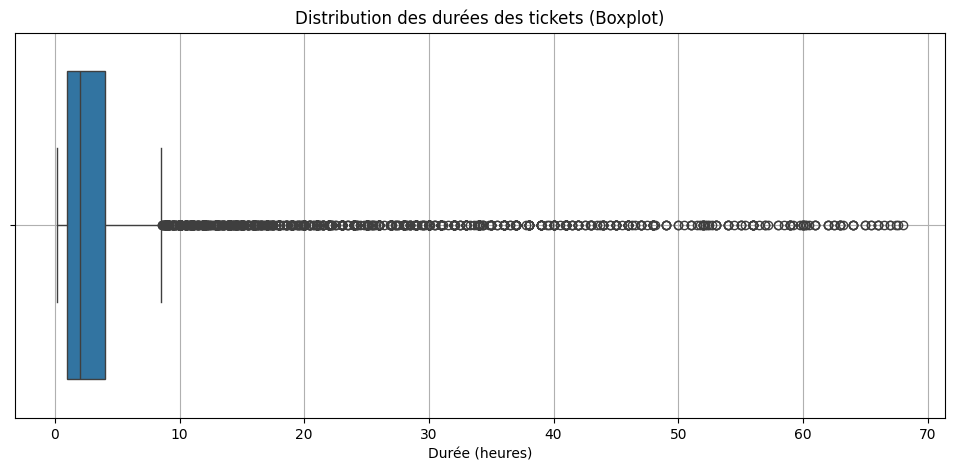

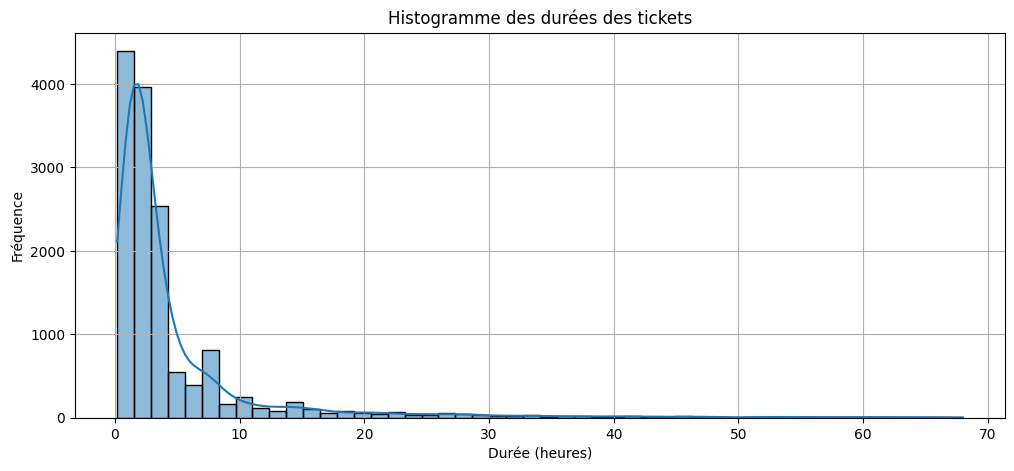

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Analyse des valeurs extrêmes de la durée -----------

# Boxplot : détecte les outliers visuellement
plt.figure(figsize=(12, 5))
sns.boxplot(x=merged_df["Duree"])
plt.title("Distribution des durées des tickets (Boxplot)")
plt.xlabel("Durée (heures)")
plt.grid(True)
plt.show()

# Histogramme avec courbe de densité
plt.figure(figsize=(12, 5))
sns.histplot(merged_df["Duree"], bins=50, kde=True)
plt.title("Histogramme des durées des tickets")
plt.xlabel("Durée (heures)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


In [14]:
# -------------------------
# Étape 3 : Vectorisation NLP du libellé Jira (TF-IDF)
# -------------------------

# Liste personnalisée de mots à ignorer
stop_words_personnalises = [
    "cordialement", "contour", "parvati", "pour", "sur", "devoir", "son", "pouvoir", "nom", "colon", "mercy", "1f497d", "nous"
]

# 🧹 Supprimer toutes les colonnes dont le nom commence par "tfidf_"
merged_df = merged_df.loc[:, ~merged_df.columns.str.startswith("tfidf_")]

# Concaténer les colonnes nettoyées
textes_concat = (merged_df["summary"].fillna("") + " " + merged_df["description"].fillna("")).str.strip()

max_len = textes_concat.str.len().max()
print("Longueur maximale :", max_len)

# Initialiser le vecteur TF-IDF
tfidf = TfidfVectorizer(max_features=max_len,
                        stop_words=stop_words_personnalises)

# Appliquer le modèle
tfidf_matrix = tfidf.fit_transform(textes_concat)

# Créer un DataFrame à partir des vecteurs
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f"tfidf_{w}" for w in tfidf.get_feature_names_out()]
)

# # Fusionner avec le DataFrame d’origine
# merged_df = pd.concat([merged_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

Longueur maximale : 26903


In [15]:
# Moyenne du poids TF-IDF pour chaque mot
mean_tfidf_weights = tfidf_df.mean().sort_values(ascending=False)

# Afficher les 20 mots les plus importants
print(mean_tfidf_weights.head(20))

tfidf_error        0.028959
tfidf_command      0.025391
tfidf_place        0.023305
tfidf_commander    0.017574
tfidf_nuxe         0.017026
tfidf_172b4d       0.016546
tfidf_sap          0.016513
tfidf_client       0.016242
tfidf_livraison    0.016151
tfidf_entrant      0.012906
tfidf_message      0.012897
tfidf_status       0.012782
tfidf_coil         0.012633
tfidf_lot          0.012532
tfidf_demand       0.012237
tfidf_problem      0.012128
tfidf_non          0.011988
tfidf_rapport      0.011976
tfidf_pas          0.011643
tfidf_thumbnail    0.011406
dtype: float64


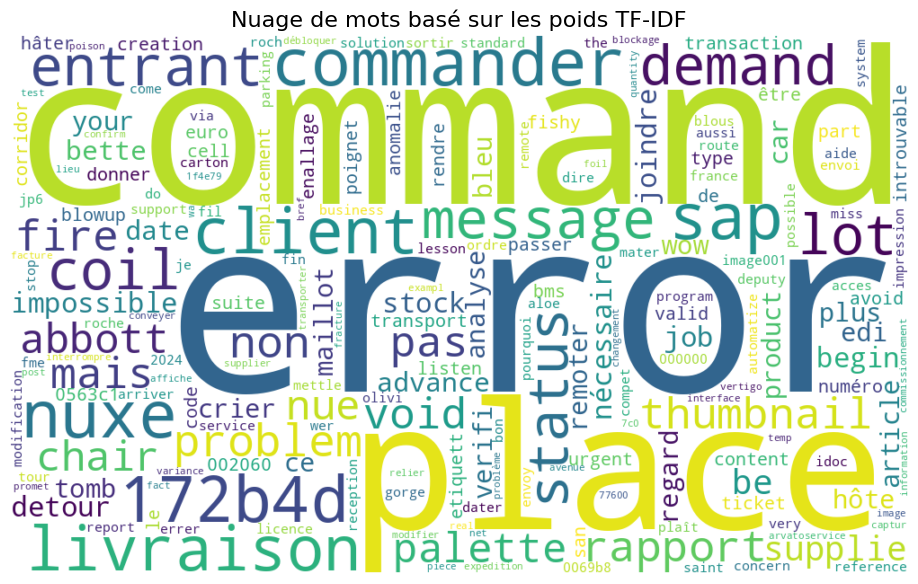

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Calculer les poids moyens TF-IDF pour chaque mot
mean_tfidf_weights = tfidf_df.mean()

# Créer un dictionnaire {mot: poids}
tfidf_dict = {word.replace("tfidf_", ""): weight for word, weight in mean_tfidf_weights.items() if weight > 0}

# Générer le nuage de mots
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(tfidf_dict)

# Afficher le nuage
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots basé sur les poids TF-IDF", fontsize=16)
plt.show()


📊 MAE avec NLP + Dates + TF-IDF : 3.3797 heures
📊 RMSE avec NLP + Dates + TF-IDF : 6.5882 heures
✅ Erreur minimale : 0.0003 heures
❌ Erreur maximale : 54.3578 heures


C:\Users\TEIX032\AppData\Local\Temp\ipykernel_18544\3543113930.py:71: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\TEIX032\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


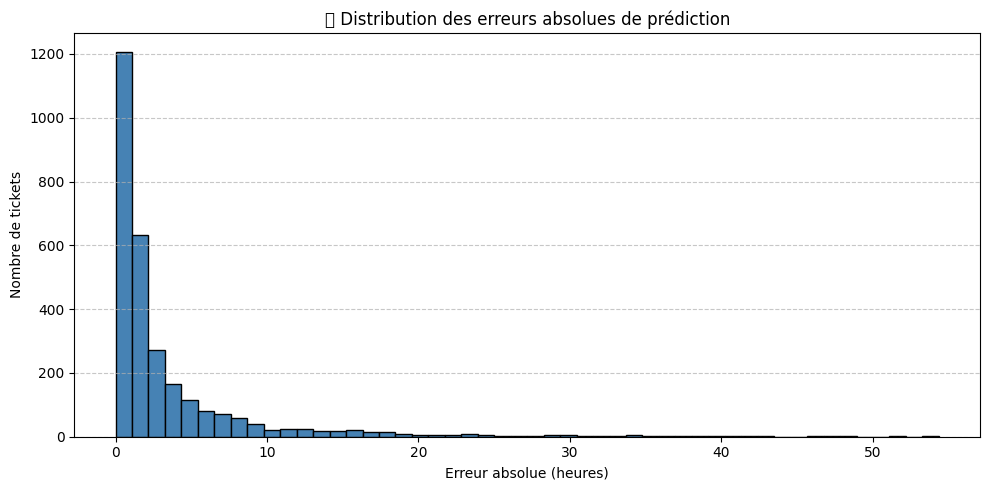

['models/tfidf_vectorizer.pkl']

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import joblib
from matplotlib import pyplot as plt

# 🧠 Colonnes catégorielles à encoder
cat_features_nlp = ["Matricule", "fields.project.key", "Type_Étendu"]
enc_nlp = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded_cat = enc_nlp.fit_transform(merged_df[cat_features_nlp])
encoded_df = pd.DataFrame(encoded_cat, columns=cat_features_nlp)

# 🔢 Variables numériques supplémentaires
cols_num = [
    "nb_key", "Historique_1an",
    # "annee_commence", "mois_commence", "jour_semaine_commence",
    "annee_creation", "mois_creation", "jour_semaine",
    "delai_creation_action_h"
]

# 🔄 Fusion finale des features pour entraînement
x_nlp = pd.concat([
    encoded_df.reset_index(drop=True),
    merged_df[cols_num].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

y_nlp = merged_df["Duree"].copy()
del merged_df

# 📊 Split
x_train_nlp, x_test_nlp, y_train_nlp, y_test_nlp = train_test_split(
    x_nlp, y_nlp, test_size=0.2, random_state=42
)

# 🧱 Pipeline : scaler + XGBoost
pipeline_nlp = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(n_estimators=100, random_state=42, verbosity=1))
])

# 🚀 Entraînement
pipeline_nlp.fit(x_train_nlp, y_train_nlp)

# 📈 Évaluation
pred_nlp = pipeline_nlp.predict(x_test_nlp)
errors = abs(y_test_nlp - pred_nlp)

# 📈 Résumé
mae = mean_absolute_error(y_test_nlp, pred_nlp)
rmse = np.sqrt(mean_squared_error(y_test_nlp, pred_nlp))
min_err = errors.min()
max_err = errors.max()

print(f"📊 MAE avec NLP + Dates + TF-IDF : {mae:.4f} heures")
print(f"📊 RMSE avec NLP + Dates + TF-IDF : {rmse:.4f} heures")
print(f"✅ Erreur minimale : {min_err:.4f} heures")
print(f"❌ Erreur maximale : {max_err:.4f} heures")

# ⚠️ Assure-toi d’avoir déjà défini `errors = abs(y_test_nlp - pred_nlp)` avant ce bloc

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='steelblue', edgecolor='black')
plt.title("📈 Distribution des erreurs absolues de prédiction")
plt.xlabel("Erreur absolue (heures)")
plt.ylabel("Nombre de tickets")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 💾 Sauvegardes
joblib.dump(pipeline_nlp, "models/xgb_pipeline_nlp.pkl")
joblib.dump(enc_nlp, "models/xgb_encoder_nlp.pkl")
joblib.dump(tfidf, "models/tfidf_vectorizer.pkl")


In [8]:
import numpy as np

# 1. Redéfinir le seuil extrême via percentile 90
seuil_extreme = mae

# 2. Index des cas extrêmes
extreme_idx = errors[errors > seuil_extreme].index

# 3. Données extrêmes
x_extreme_full = x_test_nlp.loc[extreme_idx]
y_extreme_full = y_test_nlp.loc[extreme_idx]

In [ ]:
print(f"🔢 Nombre total de cas extrêmes : {len(x_extreme_full)}")

🔢 Nombre total de cas extrêmes : 731


In [ ]:
# from xgboost import XGBRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # 4. Split train/test (80/20)
# x_ext_train, x_ext_test, y_ext_train, y_ext_test = train_test_split(
#     x_extreme_full, y_extreme_full, test_size=0.2, random_state=42
# )

# # 5. Pipeline spécialisé
# pipeline_extreme = Pipeline([
#     ("scaler", StandardScaler()),
#     ("xgb", XGBRegressor(n_estimators=100, random_state=42, verbosity=1))
# ])

# # 6. Entraînement sur le train extrême
# pipeline_extreme.fit(x_ext_train, y_ext_train)

# # 7. Prédiction sur le test extrême
# pred_extreme = pipeline_extreme.predict(x_ext_test)

# # 8. Évaluation
# mae_ext = mean_absolute_error(y_ext_test, pred_extreme)
# rmse_ext = np.sqrt(mean_squared_error(y_ext_test, pred_extreme))
# r2_ext = r2_score(y_ext_test, pred_extreme)
# min_err = np.min(np.abs(y_ext_test - pred_extreme))
# max_err = np.max(np.abs(y_ext_test - pred_extreme))

# # 9. Résultats
# print("\n📊 Évaluation du modèle extrême (test set) :")
# print(f"MAE  : {mae_ext:.4f} heures")
# print(f"RMSE : {rmse_ext:.4f} heures")
# print(f"R²   : {r2_ext:.4f}")
# print(f"✅ Erreur minimale : {min_err:.4f} h")
# print(f"❌ Erreur maximale : {max_err:.4f} h")

# # 10. Sauvegarde du modèle
# joblib.dump(pipeline_extreme, "models/xgb_pipeline_extreme.pkl")


📊 Évaluation du modèle extrême (test set) :
MAE  : 9.9638 heures
RMSE : 13.8836 heures
R²   : -0.0902
✅ Erreur minimale : 0.0580 h
❌ Erreur maximale : 58.6510 h


['models/xgb_pipeline_extreme.pkl']

In [ ]:
# # Prédictions du modèle principal
# pred_main = pipeline_nlp.predict(x_ext_test)

# # Prédictions du modèle extrême
# pred_extreme = pipeline_extreme.predict(x_ext_test)

# # Exemple : 70% du modèle extrême, 30% du modèle principal
# alpha = 0.5
# # Moyenne des deux prédictions
# pred_moyenne = alpha * pred_extreme + (1 - alpha) * pred_main

# # Évaluation
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# mae_blended = mean_absolute_error(y_ext_test, pred_moyenne)
# rmse_blended = np.sqrt(mean_squared_error(y_ext_test, pred_moyenne))
# r2_blended = r2_score(y_ext_test, pred_moyenne)

# print("\n🔀 Performances du modèle mixte (moyenne) sur cas extrêmes :")
# print(f"MAE  : {mae_blended:.4f} heures")
# print(f"RMSE : {rmse_blended:.4f} heures")
# print(f"R²   : {r2_blended:.4f}")



🔀 Performances du modèle mixte (moyenne) sur cas extrêmes :
MAE  : 9.6348 heures
RMSE : 13.5155 heures
R²   : -0.0331


______________________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
# from sentence_transformers import SentenceTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OrdinalEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from xgboost import XGBRegressor
# import pandas as pd
# import numpy as np
# import joblib
# from matplotlib import pyplot as plt

# # -------------------------
# # Étape 3 : Vectorisation NLP du libellé Jira (CamemBERT)
# # -------------------------

# # 🧠 Fusion des champs texte (summary + description)
# textes_concat = (merged_df["summary"].fillna("") + " " + merged_df["description"].fillna("")).str.strip()

# # 🔎 Chargement du modèle CamemBERT via sentence-transformers
# camembert_model = SentenceTransformer("dangvantuan/sentence-camembert-large")

# # 🧠 Génération des embeddings (vecteurs denses)
# embeddings = camembert_model.encode(textes_concat.tolist(), show_progress_bar=True)

# # 📦 Embeddings sous forme de DataFrame
# embed_df = pd.DataFrame(embeddings, columns=[f"embed_{i}" for i in range(embeddings.shape[1])])

# # -------------------------
# # Préparation des features classiques
# # -------------------------

# # 🔠 Colonnes catégorielles
# cat_features = ["Matricule", "fields.project.key", "Type_Étendu"]
# enc_camembert = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# encoded_cat = enc_camembert.fit_transform(merged_df[cat_features])
# encoded_df = pd.DataFrame(encoded_cat, columns=cat_features)

# # 🔢 Variables numériques
# cols_num = [
#     "nb_key", "Historique_1an",
#     "annee_creation", "mois_creation", "jour_semaine",
#     "delai_creation_action_h"
# ]

# # 🔄 Fusion finale des features
# x_embed = pd.concat([
#     encoded_df.reset_index(drop=True),
#     merged_df[cols_num].reset_index(drop=True),
#     embed_df.reset_index(drop=True)
# ], axis=1)

# y_embed = merged_df["Duree"].copy()

# # -------------------------
# # Entraînement
# # -------------------------

# # 🔀 Split
# x_train_emb, x_test_emb, y_train_emb, y_test_emb = train_test_split(
#     x_embed, y_embed, test_size=0.2, random_state=42
# )

# # ⚙️ Pipeline
# pipeline_embed = Pipeline([
#     ("scaler", StandardScaler()),
#     ("xgb", XGBRegressor(n_estimators=100, random_state=42, verbosity=1))
# ])

# # 🚀 Entraînement
# pipeline_embed.fit(x_train_emb, y_train_emb)

# # 🔍 Évaluation
# pred_emb = pipeline_embed.predict(x_test_emb)
# errors_emb = abs(y_test_emb - pred_emb)

# # 📊 Résumé
# mae = mean_absolute_error(y_test_emb, pred_emb)
# rmse = np.sqrt(mean_squared_error(y_test_emb, pred_emb))
# min_err = errors_emb.min()
# max_err = errors_emb.max()

# print(f"📊 MAE avec NLP + Dates + CamemBERT : {mae:.4f} heures")
# print(f"📊 RMSE avec NLP + Dates + CamemBERT : {rmse:.4f} heures")
# print(f"✅ Erreur minimale : {min_err:.4f} heures")
# print(f"❌ Erreur maximale : {max_err:.4f} heures")

# # 📈 Distribution des erreurs
# plt.figure(figsize=(10, 5))
# plt.hist(errors_emb, bins=50, color='darkorange', edgecolor='black')
# plt.title("📈 Distribution des erreurs absolues (CamemBERT)")
# plt.xlabel("Erreur absolue (heures)")
# plt.ylabel("Nombre de tickets")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # 💾 Sauvegardes (avec noms distincts)
# joblib.dump(pipeline_embed, "models/xgb_pipeline_camembert.pkl")
# joblib.dump(enc_camembert, "models/xgb_encoder_camembert.pkl")
# joblib.dump(camembert_model, "models/sentence_camembert_model.pkl")
